<a href="https://colab.research.google.com/github/Leamich/Ragaik/blob/feature%2Fcreate_segmentation_dataset/segmentation_dataset/generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Used datasets are:
- [english writing](https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database)
- [math formulas](https://drive.google.com/file/d/1noygD6Htp5n5vFgqJsFXrgc2a2qV7_Ih/view?usp=sharing)

In [ ]:
from pathlib import Path
data_path = Path("/content/data")

In [ ]:
import kagglehub
en_path = Path(kagglehub.dataset_download("nibinv23/iam-handwriting-word-database"))

In [ ]:
!ls {en_path / "iam_words/words"}

a01  a06  b05  c04  d05  e04  f03  g03	h01  h07  k01  l01  m02  n02  p02  r06
a02  b01  b06  c06  d06  e06  f04  g04	h02  j01  k02  l03  m03  n03  p03
a03  b02  c01  d01  d07  e07  f07  g05	h04  j04  k03  l04  m04  n04  p06
a04  b03  c02  d03  e01  f01  g01  g06	h05  j06  k04  l07  m06  n06  r02
a05  b04  c03  d04  e02  f02  g02  g07	h06  j07  k07  m01  n01  p01  r03


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv(
    en_path / "words_new.txt",
    names=["name", "status", "threshold", "_1", "_2", "_3", "_4", "_5", "_6"],
    usecols=["name", "status", "threshold"],
    comment="#",
    sep=" "
)

In [ ]:
def f(s):
    s = s.split("-")
    f1 = s[0]
    f2 = "-".join(s[:2])
    f3 = "-".join(s) + ".png"
    return f"{f1}/{f2}/{f3}"

df["path"] = df.name.apply(f)

In [ ]:
df.head()

,name,status,threshold,path
0,a01-000u-00-00,ok,154,a01/a01-000u/a01-000u-00-00.png
1,a01-000u-00-01,ok,154,a01/a01-000u/a01-000u-00-01.png
2,a01-000u-00-02,ok,154,a01/a01-000u/a01-000u-00-02.png
3,a01-000u-00-03,ok,154,a01/a01-000u/a01-000u-00-03.png
4,a01-000u-00-04,ok,154,a01/a01-000u/a01-000u-00-04.png


In [ ]:
import os
import shutil
import argparse
import numpy as np
from numpy import typing as np_typing

from PIL import Image

In [ ]:
from glob import glob

In [ ]:
import cv2

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
result_path = data_path / "en_images"

In [ ]:
!rm -rf {result_path}

In [ ]:
result_path.mkdir(parents=True, exist_ok=True)

In [ ]:
for path, threshold in tqdm(df.loc[df.status == "ok", ["path", "threshold"]].itertuples(index=False)):
    path = en_path / "iam_words/words" / Path(path)
    # print(im)
    im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    _, im = cv2.threshold(im, threshold, 255, cv2.THRESH_BINARY)
    # print(_, im)
    try:
        cv2.imwrite(str(result_path / path.name), im)
    except Exception:
        print(f"Skipped {path.name}")

0it [00:00, ?it/s]

Skipped a01-117-05-02.png


In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt

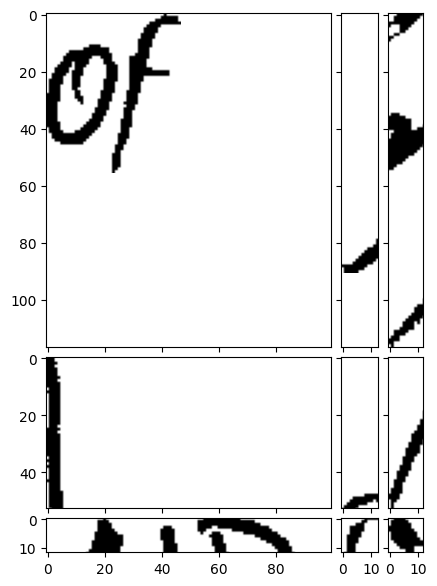

In [ ]:
sample = np.random.choice(list(result_path.glob("**/*.png")), size=9)

fig = plt.figure(figsize=(7., 7.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, 3),  # creates 2x2 grid of Axes
                 axes_pad=0.1,  # pad between Axes in inch.
                 )

for ax, im in zip(grid, sample):
    ax.imshow(cv2.imread(im))

plt.show()

In [ ]:
ws, hs = [], []
for im in result_path.glob("*.png"):
    h, w = cv2.imread(im, cv2.IMREAD_GRAYSCALE).shape
    ws.append(w)
    hs.append(h)
ws = np.array(ws)
hs = np.array(hs)

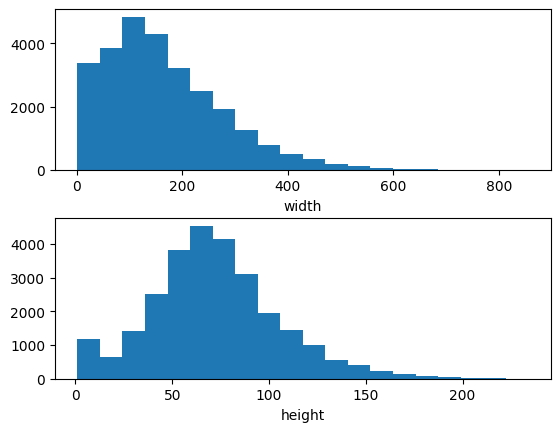

In [ ]:
_, [ax1, ax2] = plt.subplots(2, 1)
ax1.hist(ws, bins=20), ax1.set_xlabel("width")
ax2.hist(hs, bins=20), ax2.set_xlabel("height")
plt.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

drive_path = Path("/content/gdrive/MyDrive/ragaik")

Mounted at /content/gdrive


In [ ]:
!ls {drive_path}

 CROHME2019_png.zip   CROHME23.zip   sample_aik_ru_text
 CROHME23_inkml.zip   ltx_ocr	    'sample_ensembling dataset'


In [ ]:
!unzip {drive_path / "CROHME2019_png.zip"} -d {data_path / "math_raw"}

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/math_raw/CROHME2019_png/train/73_caue.png  
  inflating: /content/data/math_raw/CROHME2019_png/train/73_david.png  
  inflating: /content/data/math_raw/CROHME2019_png/train/73_edwin.png  
  inflating: /content/data/math_raw/CROHME2019_png/train/73_Fabricio.png  
  inflating: /content/data/math_raw/CROHME2019_png/train/73_Frank.png  
  inflating: /content/data/math_raw/CROHME2019_png/train/73_fujita.png  
  inflating: /content/data/math_raw/CROHME2019_png/train/73_herbert.png  
  inflating: /content/data/math_raw/CROHME2019_png/train/73_hirata.png  
  inflating: /content/data/math_raw/CROHME2019_png/train/73_jorge.png  
  inflating: /content/data/math_raw/CROHME2019_png/train/73_leissi.png  
  inflating: /content/data/math_raw/CROHME2019_png/train/73_leo.png  
  inflating: /content/data/math_raw/CROHME2019_png/train/73_maira.png  
  inflating: /content/data/math_raw/CROHME2019_png/train/73_miguel.png  
  infla

In [ ]:
paths = list((data_path / "math_raw").glob("**/*.png"))

In [ ]:
def crop_image(img):
    _, img = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)
    # print(np.unique(img))
    cs = np.argwhere(img == 0)
    max_i, max_j = np.max(cs, axis=0)
    min_i, min_j = np.min(cs, axis=0)
    return img[min_i:max_i, min_j:max_j]

In [ ]:
result_path = data_path / "math_all"

In [ ]:
!rm -rf {result_path}

In [ ]:
result_path.mkdir(exist_ok=True)

In [ ]:
for path in tqdm(paths):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = crop_image(img)
    cv2.imwrite(str(result_path / path.name), img)

  0%|          | 0/9508 [00:00<?, ?it/s]

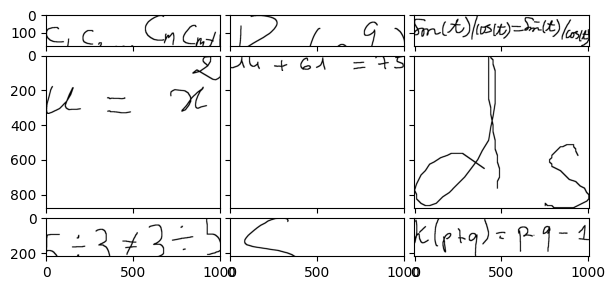

In [ ]:
sample = np.random.choice(list(result_path.glob("**/*.png")), size=9)

fig = plt.figure(figsize=(7., 7.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, 3),  # creates 2x2 grid of Axes
                 axes_pad=0.1,  # pad between Axes in inch.
                 )

for ax, im in zip(grid, sample):
    ax.imshow(cv2.imread(im))

plt.show()

In [ ]:
ws, hs = [], []
for im in result_path.glob("*.png"):
    h, w = cv2.imread(im).shape[:2]
    ws.append(w)
    hs.append(h)
ws = np.array(ws)
hs = np.array(hs)

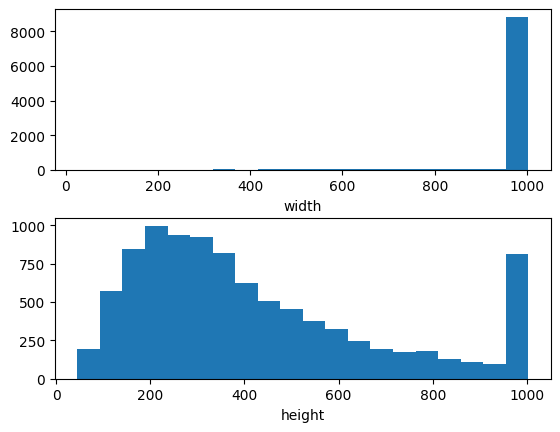

In [ ]:
_, [ax1, ax2] = plt.subplots(2, 1)
ax1.hist(ws, bins=20), ax1.set_xlabel("width")
ax2.hist(hs, bins=20), ax2.set_xlabel("height")
plt.subplots_adjust(hspace=0.3)
plt.show()

### Then combine the shit into one images (and also generate labels)

In [ ]:
import numpy as np
rng = np.random.default_rng(42)

In [ ]:
W, H = 1920, 1080
LINES_HEIGHT = 100
MAX_ATTEMPTS = 10 ** 4

def get_coords(n_lines: int):
    lines = []
    _steps = 0
    for steps in range(MAX_ATTEMPTS):
        st = rng.integers(0, H)
        en = st + LINES_HEIGHT
        if not any((st <= st0 < en or st <= en0 < en)  for st0, en0 in lines):
            if en < H:
                lines.append((st, en))
        _steps = steps
        if len(lines) == n_lines:
            break
    return lines, _steps

In [ ]:
from typing import Optional

In [ ]:
def place_in_line(ims: list, line, ys: Optional[list] = None):
    if ys is None:
        ys = [0] * len(ims)

    st, en = line
    md = (st + en) // 2
    last = 0

    def try_to_place(last, im):
        d = rng.integers(0, 40)
        if (last + d + im.shape[1]) > W:
            return False, (-1, -1)
        return True, (last + d, -(im.shape[0] // 2))

    suc = True
    res = []
    while suc and ims:
        suc, (x, y) = try_to_place(last, ims[-1])
        # print(x, ims[-1].shape[1])
        if suc:
            res.append((ims[-1], ys[-1], (x, y + md)))
            last = x + ims[-1].shape[1]
            ims.pop(), ys.pop()
    return res

In [ ]:
def rescale(img):
    h, w = img.shape
    scale = (110 - rng.random() * 30) / h
    # print(scale, (h, w))
    return cv2.resize(img, (int(w * scale), int(h * scale)))

In [ ]:
BATCH_SIZE = 100
HEIGHT_THRESHOLD = 100

def load_batch(img_path):
    # 1 - text, 0 - math
    batch_paths = rng.choice(img_path, size=BATCH_SIZE, replace=False)
    ys = [p.name.startswith("a") for p in batch_paths]
    imgs = [
        rescale(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
        for path in batch_paths
        # if img.shape[0] >= HEIGHT_THRESHOLD
    ]
    return imgs, ys

In [ ]:
def gen_image(data, add_boxes=False):
    result = np.zeros((H, W), np.uint8)
    result[:, :] = 255
    data_placed = []
    for img, label, (x, y) in data:
        try:
            # print((x, y))
            if add_boxes:
                result = cv2.rectangle(result, (x, y), (x + img.shape[1], y + img.shape[0]), 0, 2)
            result[y:(y + img.shape[0]), x:(x + img.shape[1])] = img
        except Exception as e:
            pass
            # print(f"gen_image: Exception {e}")
        else:
            data_placed.append((img, label, (x, y)))
    return result, data_placed

In [ ]:
paths = list((data_path / "en_images").glob("**/*.png")) + \
        list((data_path / "math_all").glob("**/*.png"))

batch, _ = load_batch(paths)
lines, _ = get_coords(rng.integers(7, 10))
res = []
for line in lines:
    res += place_in_line(batch, line)

img, _ = gen_image(res, add_boxes=True)

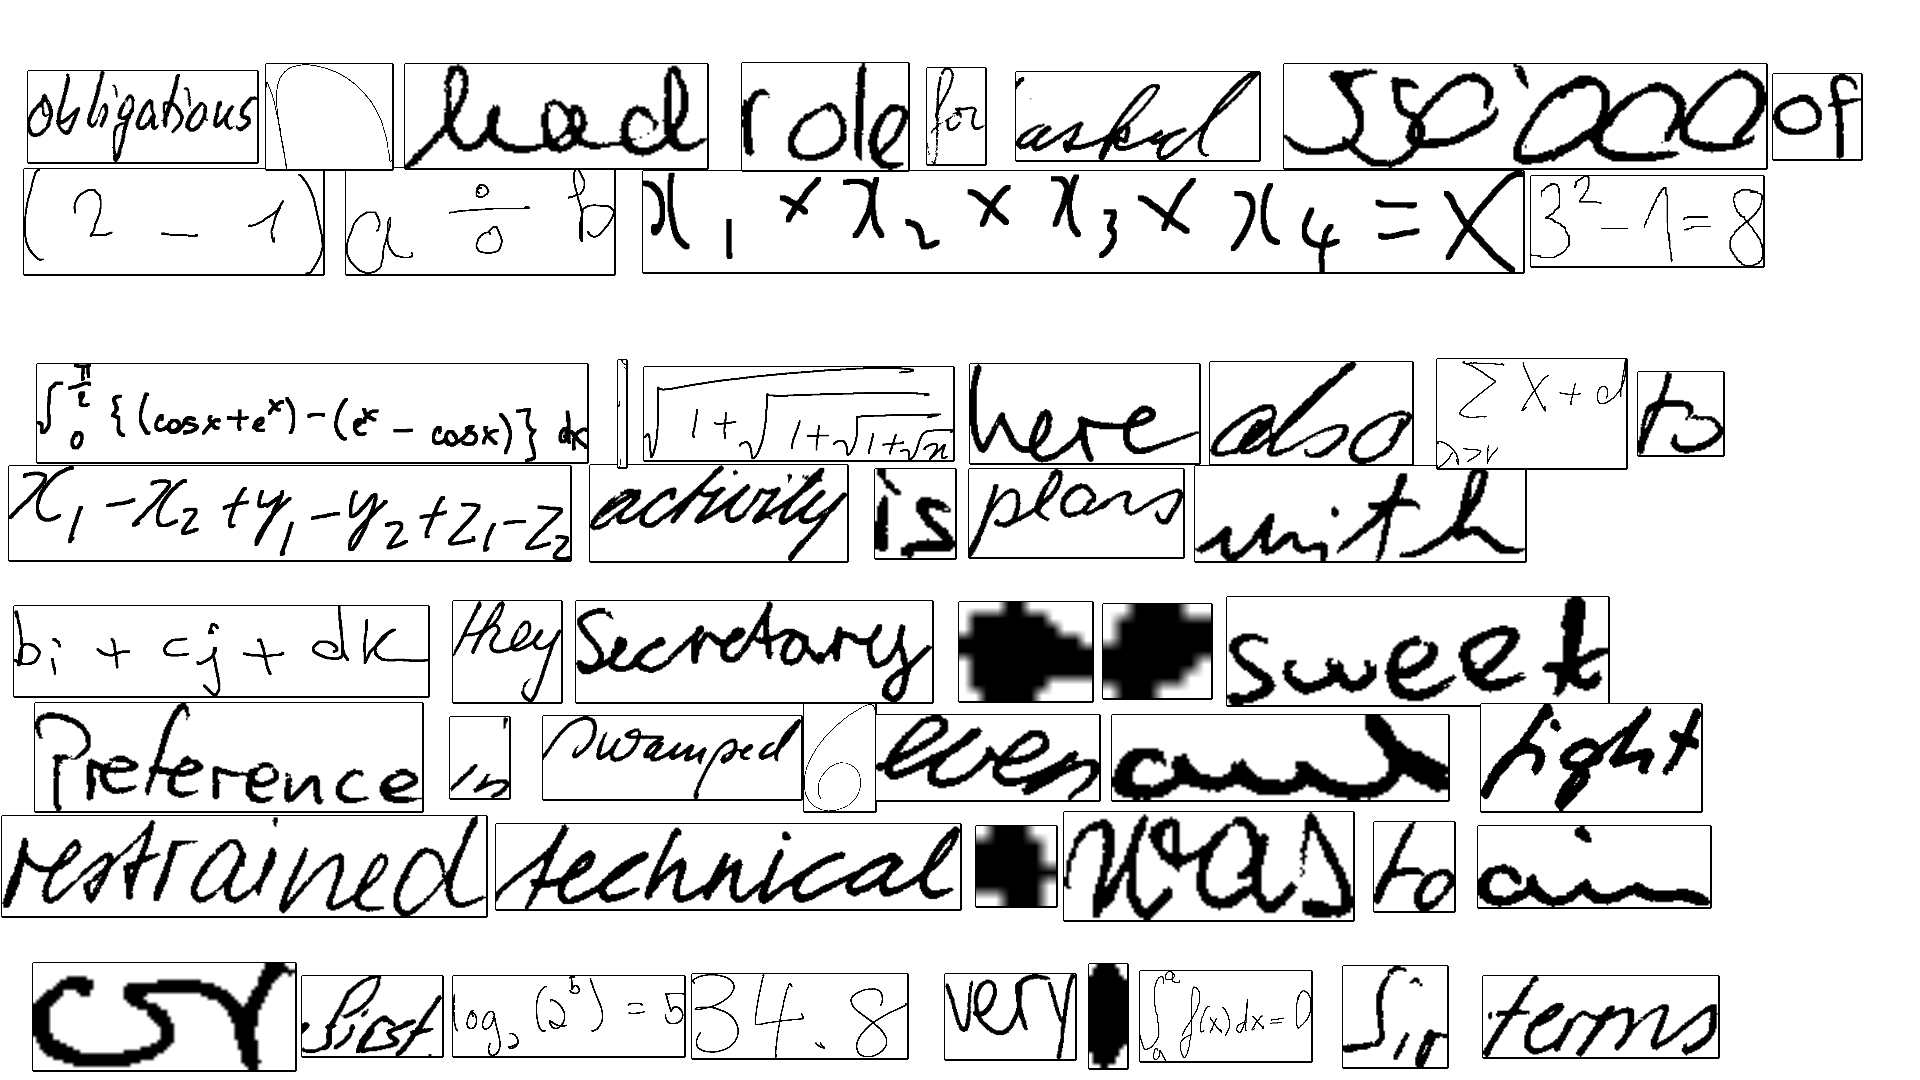

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

In [ ]:
DATASET_SIZE = 9

paths = list((data_path / "en_images").glob("**/*.png")) + \
        list((data_path / "math_all").glob("**/*.png"))

imgs = []

for step in tqdm(range(DATASET_SIZE)):
    batch, _ = load_batch(paths)
    lines, _ = get_coords(rng.integers(7, 10))
    res = []
    for line in lines:
        res += place_in_line(batch, line)
    imgs.append(gen_image(res)[0])

  0%|          | 0/9 [00:00<?, ?it/s]

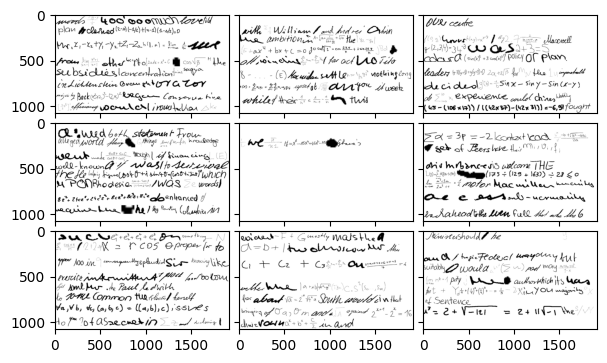

In [ ]:
fig = plt.figure(figsize=(7., 7.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, 3),  # creates 2x2 grid of Axes
                 axes_pad=0.1,  # pad between Axes in inch.
                 )

for ax, im in zip(grid, imgs):
    ax.imshow(im, cmap="gray", vmin=0, vmax=255)

plt.show()

In [ ]:
train_path = data_path / "train"
val_path = data_path / "val"
test_path = data_path / "test"

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
paths = list((data_path / "en_images").glob("**/*.png")) + \
        list((data_path / "math_all").glob("**/*.png"))

train, testval = train_test_split(
    paths, train_size=0.8, random_state=42,
)

In [ ]:
test, val = train_test_split(
    testval, train_size=0.5, random_state=42,
)

In [ ]:
train_path.mkdir(exist_ok=True)
test_path.mkdir(exist_ok=True)
val_path.mkdir(exist_ok=True)

In [ ]:
for p in train:
    shutil.copy(p, train_path)
for p in val:
    shutil.copy(p, val_path)
for p in test:
    shutil.copy(p, test_path)

In [ ]:
def make_dataset(folder_from, folder_to):
    folder_to.mkdir(exist_ok=True, parents=True)
    paths = list(folder_from.glob("*.png"))
    dataset_size = len(paths) // 3
    for step in tqdm(range(dataset_size)):
        batch, ys = load_batch(paths)
        lines, _ = get_coords(rng.integers(7, 10))
        res = []
        for line in lines:
            res += place_in_line(batch, line)
        img, res = gen_image(res)
        cv2.imwrite(folder_to / f"{step:06d}.png", img)

        preds = []
        for im, label, (x, y) in res:
            preds.append(np.array([np.float64(im.shape[1]) / 2 + x, np.float64(im.shape[0]) / 2 + y, im.shape[1], im.shape[0]]) / np.array([W, H, W, H], dtype=np.float64))
        preds = np.array(preds, dtype=np.float64)
        np.savetxt(folder_to / f"{step:06d}.txt", preds, fmt="%.8f")

In [ ]:
make_dataset(test_path, data_path / "yolo_data/test/")

  0%|          | 0/1226 [00:00<?, ?it/s]

In [ ]:
!ls {data_path / "yolo_data/test/"}

000000.png  000204.txt	000409.png  000613.txt	000818.png  001022.txt
000000.txt  000205.png	000409.txt  000614.png	000818.txt  001023.png
000001.png  000205.txt	000410.png  000614.txt	000819.png  001023.txt
000001.txt  000206.png	000410.txt  000615.png	000819.txt  001024.png
000002.png  000206.txt	000411.png  000615.txt	000820.png  001024.txt
000002.txt  000207.png	000411.txt  000616.png	000820.txt  001025.png
000003.png  000207.txt	000412.png  000616.txt	000821.png  001025.txt
000003.txt  000208.png	000412.txt  000617.png	000821.txt  001026.png
000004.png  000208.txt	000413.png  000617.txt	000822.png  001026.txt
000004.txt  000209.png	000413.txt  000618.png	000822.txt  001027.png
000005.png  000209.txt	000414.png  000618.txt	000823.png  001027.txt
000005.txt  000210.png	000414.txt  000619.png	000823.txt  001028.png
000006.png  000210.txt	000415.png  000619.txt	000824.png  001028.txt
000006.txt  000211.png	000415.txt  000620.png	000824.txt  001029.png
000007.png  000211.txt	000416.png 

In [ ]:
!head {data_path / "yolo_data/test/000000.txt"} -n 5

0.03515625 0.78333333 0.05677083 0.07592593
0.08932292 0.78333333 0.02447917 0.07592593
0.18125000 0.78379630 0.14791667 0.08611111
0.33203125 0.78379630 0.13281250 0.09351852
0.46197917 0.78333333 0.10416667 0.09074074


In [ ]:
make_dataset(train_path, data_path / "yolo_data/train/")

  0%|          | 0/9813 [00:00<?, ?it/s]

In [ ]:
make_dataset(val_path, data_path / "yolo_data/val/")

  0%|          | 0/1227 [00:00<?, ?it/s]

In [ ]:
!zip -r -3 data.zip {data_path / "yolo_data"}

Streaming output truncated to the last 5000 lines.
  adding: content/data/yolo_data/train/000106.txt (deflated 69%)
  adding: content/data/yolo_data/train/003555.txt (deflated 67%)
  adding: content/data/yolo_data/train/005422.png (deflated 6%)
  adding: content/data/yolo_data/train/006219.txt (deflated 67%)
  adding: content/data/yolo_data/train/009499.txt (deflated 68%)
  adding: content/data/yolo_data/train/006185.png (deflated 4%)
  adding: content/data/yolo_data/train/008363.png (deflated 5%)
  adding: content/data/yolo_data/train/003009.txt (deflated 67%)
  adding: content/data/yolo_data/train/006145.png (deflated 4%)
  adding: content/data/yolo_data/train/009720.png (deflated 5%)
  adding: content/data/yolo_data/train/006087.txt (deflated 68%)
  adding: content/data/yolo_data/train/003299.png (deflated 4%)
  adding: content/data/yolo_data/train/003936.png (deflated 4%)
  adding: content/data/yolo_data/train/009387.png (deflated 6%)
  adding: content/data/yolo_data/train/003225.p

In [ ]:
!du -sh data.zip

1.9G	data.zip


In [ ]:
!cp data.zip {drive_path / "yolo_data.zip"}

# Legacy code

In [ ]:
BINARIZATION_BLOCK_SIZE = 15
BINARIZATION_C = 9 # more small - more sensitive


def binarize_image(img):
    return cv2.adaptiveThreshold(
            img,
            maxValue=255,
            adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            thresholdType=cv2.THRESH_BINARY,
            blockSize=BINARIZATION_BLOCK_SIZE,
            C=BINARIZATION_C
        )

def process_image(img_path, result_folder):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = binarize_image(img)
    # print(os.path.join(result_folder, os.path.basename(img_path)))
    cv2.imwrite(os.path.join(result_folder, os.path.basename(img_path)), img)


def process_image_folder(img_folder, result_folder, limit=-1):
    os.makedirs(result_folder, exist_ok=True)
    imgs = glob(os.path.join(img_folder, "**/*.png"), recursive=True)
    if limit > 0:
        imgs = imgs[:limit]
    for img_path in tqdm(imgs):
        process_image(img_path, result_folder)

In [ ]:
!rm -rf {data_path / 'russian_out'}

In [ ]:
process_image_folder(ru_path, str(data_path / 'russian_out'))

  0%|          | 0/73830 [00:00<?, ?it/s]